# PDF Chat Solution with LLM

A simple and lightweight solution to chat with PDF documents using LLM (Large Language Models).

## Features
- Extract text and images from PDF files
- Summarize PDF content using LLM
- Ask questions about the PDF content
- Support for both Mistral and OpenAI models
- Save extracted images as JPG files
- Self-contained with all required PDF processing functions included

## Requirements
Make sure you have the following packages installed:
```bash
pip install pdfplumber pymupdf pillow mistralai openai
```

## What's Included
- **PDF Text Extraction**: Extract text, tables, and hyperlinks from PDF files
- **PDF Image Extraction**: Extract and save images from PDF files as JPG
- **LLM Integration**: Chat with your PDF using Mistral or OpenAI models
- **Streaming Support**: Real-time text generation responses
- **No External Dependencies**: All PDF processing functions are included in the notebook

## Setup and Configuration

In [1]:
# Install required packages (uncomment if needed)
!pip install pdfplumber pymupdf pillow mistralai openai

### PDF Image Extraction Function

This function extracts images from PDF files and saves them as JPG files.

In [2]:
def extract_images_from_pdf(pdf_path: str, output_dir: str = None, debug: bool = False):
    """
    Extract images from PDF and save them as JPG files with proper colorspace handling.
    
    This enhanced version properly handles CMYK colorspace conversion and provides
    debugging information to identify why images might appear blank.
    
    Args:
        pdf_path (str): Path to the PDF file
        output_dir (str): Directory to save extracted images (default: same as PDF)
        debug (bool): Enable debug output to troubleshoot image extraction issues
        
    Returns:
        List[Dict]: List of dictionaries containing image information with keys:
                   - page_number: Page number where image was found
                   - image_index: Index of image on that page
                   - filename: Name of the saved image file
                   - path: Full path to the saved image
                   - width: Image width in pixels
                   - height: Image height in pixels
                   - size_bytes: Size of image data in bytes
                   - colorspace: Original colorspace of the image
                   - converted: Whether colorspace conversion was applied
    """
    import fitz  # PyMuPDF
    import os
    from typing import List, Dict, Any
    import io
    from PIL import Image
    
    if output_dir is None:
        output_dir = os.path.dirname(pdf_path)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Open PDF
    doc = fitz.open(pdf_path)
    
    image_info = []
    image_count = 0
    
    # Base name for output files
    base_name = os.path.splitext(os.path.basename(pdf_path))[0]
    
    if debug:
        print(f"🔍 Starting image extraction from: {pdf_path}")
        print(f"📄 Total pages: {len(doc)}")
    
    # Iterate through pages
    for page_num in range(len(doc)):
        page = doc[page_num]
        image_list = page.get_images(full=True)
        
        if debug and image_list:
            print(f"📄 Page {page_num + 1}: Found {len(image_list)} images")
        
        # Extract images from this page
        for img_index, img in enumerate(image_list):
            xref = img[0]
            
            try:
                # Method 1: Try direct pixmap extraction (recommended)
                pix = fitz.Pixmap(doc, xref)
                
                if debug:
                    colorspace_name = pix.colorspace.name if pix.colorspace else "Unknown"
                    print(f"  🖼️  Image {img_index + 1}: {pix.width}x{pix.height}, "
                          f"colorspace: {colorspace_name}, channels: {pix.n}")
                
                # Skip if image is too small
                if pix.width < 50 or pix.height < 50:
                    if debug:
                        print(f"    ⚠️  Skipping small image: {pix.width}x{pix.height}")
                    pix = None
                    continue
                
                converted = False
                original_colorspace = pix.colorspace.name if pix.colorspace else "Unknown"
                
                # Enhanced colorspace handling
                if pix.colorspace is None:
                    if debug:
                        print(f"    ⚠️  No colorspace information, trying alternative method")
                    # Try alternative extraction method
                    pix = None
                    img_dict = doc.extract_image(xref)
                    img_data = img_dict["image"]
                    
                    # Save using PIL directly
                    image_filename = f"{base_name}_page{page_num + 1}_img{img_index + 1}.jpg"
                    image_path = os.path.join(output_dir, image_filename)
                    
                    with open(image_path, "wb") as img_file:
                        img_file.write(img_data)
                    
                    # Try to get dimensions from PIL
                    try:
                        with Image.open(io.BytesIO(img_data)) as pil_img:
                            width, height = pil_img.size
                    except:
                        width, height = 0, 0
                    
                    image_info.append({
                        "page_number": page_num + 1,
                        "image_index": img_index + 1,
                        "filename": image_filename,
                        "path": image_path,
                        "width": width,
                        "height": height,
                        "size_bytes": len(img_data),
                        "colorspace": "Unknown",
                        "converted": False,
                        "extraction_method": "direct_bytes"
                    })
                    
                    image_count += 1
                    if debug:
                        print(f"    ✅ Saved using direct bytes method")
                    continue
                
                # Handle different colorspaces
                if pix.colorspace and pix.colorspace.name in ["DeviceCMYK", "CMYK"]:
                    if debug:
                        print(f"    🔄 Converting CMYK to RGB")
                    # Convert CMYK to RGB
                    rgb_pix = fitz.Pixmap(fitz.csRGB, pix)
                    pix = rgb_pix
                    converted = True
                    
                elif pix.n - pix.alpha > 4:  # More than 4 channels (likely CMYK with alpha)
                    if debug:
                        print(f"    🔄 Converting multi-channel image to RGB")
                    rgb_pix = fitz.Pixmap(fitz.csRGB, pix)
                    pix = rgb_pix
                    converted = True
                
                elif pix.n - pix.alpha == 4:  # Exactly 4 channels, likely CMYK
                    if debug:
                        print(f"    🔄 Converting 4-channel image to RGB")
                    rgb_pix = fitz.Pixmap(fitz.csRGB, pix)
                    pix = rgb_pix
                    converted = True
                
                # Save the image
                image_filename = f"{base_name}_page{page_num + 1}_img{img_index + 1}.jpg"
                image_path = os.path.join(output_dir, image_filename)
                
                # Save as PNG first to preserve quality, then convert to JPG
                png_data = pix.tobytes("png")
                
                # Use PIL for final JPG conversion to ensure quality
                pil_image = Image.open(io.BytesIO(png_data))
                
                # Ensure RGB mode for JPG
                if pil_image.mode in ("RGBA", "LA", "P"):
                    pil_image = pil_image.convert("RGB")
                elif pil_image.mode not in ("RGB", "L"):
                    pil_image = pil_image.convert("RGB")
                
                # Save as high-quality JPG
                pil_image.save(image_path, "JPEG", quality=95, optimize=True)
                
                # Store image information
                image_info.append({
                    "page_number": page_num + 1,
                    "image_index": img_index + 1,
                    "filename": image_filename,
                    "path": image_path,
                    "width": pix.width,
                    "height": pix.height,
                    "size_bytes": len(png_data),
                    "colorspace": original_colorspace,
                    "converted": converted,
                    "extraction_method": "pixmap"
                })
                
                image_count += 1
                
                if debug:
                    conversion_msg = " (converted)" if converted else ""
                    print(f"    ✅ Saved: {image_filename}{conversion_msg}")
                
            except Exception as e:
                if debug:
                    print(f"    ❌ Error extracting image {img_index + 1}: {e}")
                    print(f"    🔄 Trying alternative extraction method...")
                
                # Alternative extraction method
                try:
                    img_dict = doc.extract_image(xref)
                    img_data = img_dict["image"]
                    
                    image_filename = f"{base_name}_page{page_num + 1}_img{img_index + 1}.jpg"
                    image_path = os.path.join(output_dir, image_filename)
                    
                    # Save directly
                    with open(image_path, "wb") as img_file:
                        img_file.write(img_data)
                    
                    # Try to get dimensions
                    try:
                        with Image.open(io.BytesIO(img_data)) as pil_img:
                            width, height = pil_img.size
                    except:
                        width, height = 0, 0
                    
                    image_info.append({
                        "page_number": page_num + 1,
                        "image_index": img_index + 1,
                        "filename": image_filename,
                        "path": image_path,
                        "width": width,
                        "height": height,
                        "size_bytes": len(img_data),
                        "colorspace": "Unknown",
                        "converted": False,
                        "extraction_method": "fallback"
                    })
                    
                    image_count += 1
                    if debug:
                        print(f"    ✅ Saved using fallback method")
                        
                except Exception as e2:
                    if debug:
                        print(f"    ❌ Both methods failed: {e2}")
                    continue
            
            finally:
                # Clean up pixmap to free memory
                if 'pix' in locals() and pix:
                    pix = None
    
    # Close document
    doc.close()
    
    success_msg = f"✅ Successfully extracted {image_count} images from {pdf_path}"
    if debug:
        print(f"\n{success_msg}")
        if image_info:
            print("\n📊 Extraction Summary:")
            for img in image_info:
                method = img.get('extraction_method', 'pixmap')
                converted = ' (converted)' if img.get('converted', False) else ''
                print(f"  • {img['filename']}: {img['width']}x{img['height']}, "
                      f"{img['colorspace']}{converted} [{method}]")
    else:
        print(success_msg)
    
    return image_info

### PDF Text Extraction Function

This function extracts text content from PDF files, including tables and hyperlinks.

In [3]:
def write_text_to_file(outputfile, text, table_text):
    """
    Write text and table data to a file.
    
    Args:
        outputfile (str): Path to the output text file
        text (str): Main text content
        table_text (str): Table content in text format
        
    Returns:
        str: Combined text content
    """
    combined_text = text + "\n\n" + table_text
    with open(outputfile, 'w', encoding='utf-8') as text_file:
        text_file.write(combined_text)
    return combined_text

def pdf_to_text(file_path, outputfile, extracttables=True, extractimages=False):
    """
    Extract text from PDF file, including tables and hyperlinks.
    
    Args:
        file_path (str): Path to the PDF file
        outputfile (str): Path to save the extracted text
        extracttables (bool): Whether to extract tables (default: True)
        extractimages (bool): Whether to extract images (default: False)
        
    Returns:
        str: Extracted text content
    """
    import pdfplumber
    
    text = ""
    with pdfplumber.open(file_path) as pdf:
        # Extract text from all pages
        text = "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])
        
        # Extract hyperlinks
        try:
            hyperlinks_text = "\n".join([str(hyperlink) for hyperlink in pdf.hyperlinks])
            text = "\n".join([text, "\nHyperlinks and Annotations in the document:", hyperlinks_text])
        except Exception as e:
            print(f"Warning: Could not extract hyperlinks: {e}")

    # Extract tables if requested
    table_text = ""
    if extracttables:
        table_text = extract_tables_from_pdf(file_path)
    
    # Write to file and return content
    return write_text_to_file(outputfile, text, table_text)

### PDF Table Extraction Function

This function extracts tables from PDF files and formats them as text.

## PDF Processing Functions

The following cells contain the required functions for PDF text and image extraction. These functions are self-contained and don't require external files.

In [4]:
def extract_tables_from_pdf(file_path):
    """
    Extract table data in text format from PDF file.
    
    Args:
        file_path (str): Path to the PDF file
        
    Returns:
        str: Formatted table text with all tables found in the PDF
    """
    import pdfplumber
    
    counter = 1
    with pdfplumber.open(file_path) as pdf:
        table_text = []
        for page in pdf.pages:
            tables = page.extract_tables()
            for table in tables:
                table_text.append("Table "+str(counter)+"\n")
                for row in table:
                    table_text.append(" | ".join([str(cell) for cell in row]))
                table_text.append("\n")
                counter = counter+1
    return "\n".join(table_text)

In [5]:
import os
import json
import sys
from typing import Dict, Any, List, Optional
from pathlib import Path

# Import LLM clients
try:
    from mistralai import Mistral, UserMessage, SystemMessage, AssistantMessage, ToolMessage
    MISTRAL_AVAILABLE = True
except ImportError:
    MISTRAL_AVAILABLE = False
    print("Mistral client not available. Install with: pip install mistralai")

try:
    import openai
    OPENAI_AVAILABLE = True
except ImportError:
    OPENAI_AVAILABLE = False
    print("OpenAI client not available. Install with: pip install openai")

print(f"Mistral available: {MISTRAL_AVAILABLE}")
print(f"OpenAI available: {OPENAI_AVAILABLE}")

print("All required PDF processing functions are now included in the notebook!")

Mistral available: True
OpenAI available: True
All required PDF processing functions are now included in the notebook!


## Configure API Keys

Set your API keys here. You can get free API keys from:
- **Mistral**: https://console.mistral.ai/
- **OpenAI**: https://platform.openai.com/
- Store the openai api key in ~/openai.key file.
- Store the mistral api key in ~/mistral.key file.

**Note:**
- "~" is your home directory.
- In case of Mac, home directory: /home/<mac_user_name>
- In case of Windows, it is C:\Users\<windows_user_name>


In [6]:
OPENAI_KEY = "OPENAI_KEY"
OPENAI_API_KEY_FILE_NAME = "openai.key"

MISTRAL_KEY = "MISTRAL_KEY"
MISTRAL_API_KEY_FILE_NAME = "mistral.key"

ANTHROPIC_CLAUDE_KEY = "ANTHROPIC_CLAUDE_KEY"
ANTHROPIC_CLAUDE_KEY_FILE_NAME = "anthropic.key"

GROK_KEY = "GROK_KEY"
GROK_KEY_FILE_NAME = "grok.key"

GEMINI_KEY = "GEMINI_KEY"
GEMINI_KEY_FILE_NAME = "gemini.key"

def get_api_key(keyName, keyFileName):
    key = "Not Set"
    try:
        key = os.environ[keyName]
    except:
        file_name = os.path.join(os.path.expanduser('~'), keyFileName)
        key_file_name = Path(file_name)
        if key_file_name.exists():
            with open(file_name, "r") as keyfile:
                key = keyfile.read().strip()
        else:
            errMessage = "{keyName} is not found"
            print(errMessage.format(keyName=keyName))
    return key

def get_openai_api_key():
    return get_api_key(OPENAI_KEY, OPENAI_API_KEY_FILE_NAME)

def get_mistral_api_key():
    return get_api_key(MISTRAL_KEY, MISTRAL_API_KEY_FILE_NAME)

OPENAI_API_KEY = get_openai_api_key()
MISTRAL_API_KEY = get_mistral_api_key()

In [7]:
# Configuration
CONFIG = {
    "mistral_api_key": os.getenv("MISTRAL_API_KEY", MISTRAL_API_KEY),
    "openai_api_key": os.getenv("OPENAI_API_KEY", OPENAI_API_KEY),
    "model_provider": "mistral",  # or "openai"
    "mistral_model": "mistral-large-latest",
    "openai_model": "gpt-3.5-turbo",
    "max_tokens": 4000
}

# You can change the model provider here
# CONFIG["model_provider"] = "openai"  # Switch to OpenAI

print(f"Using {CONFIG['model_provider'].upper()} as LLM provider")

Using MISTRAL as LLM provider


## PDF Chat Class

In [8]:
class PDFChatBot:
    """Simple PDF Chat Bot with LLM integration"""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.pdf_content = None
        self.pdf_path = None
        self.extracted_images = []
        
        # Initialize LLM client
        if config["model_provider"] == "mistral":
            if not MISTRAL_AVAILABLE:
                raise ImportError("Mistral client not available")
            self.client = Mistral(api_key=config["mistral_api_key"])
        elif config["model_provider"] == "openai":
            if not OPENAI_AVAILABLE:
                raise ImportError("OpenAI client not available")
            openai.api_key = config["openai_api_key"]
            self.client = openai
        else:
            raise ValueError(f"Unsupported model provider: {config['model_provider']}")
    
    def load_pdf(self, pdf_path: str, extract_images: bool = True, debug: bool = False) -> Dict[str, Any]:
        """Load and process PDF file"""
        if not os.path.exists(pdf_path):
            raise FileNotFoundError(f"PDF file not found: {pdf_path}")
        
        self.pdf_path = pdf_path
        print(f"Loading PDF: {pdf_path}")
        
        # Extract text
        output_dir = os.path.dirname(pdf_path) or "."
        text_output = os.path.join(output_dir, os.path.splitext(os.path.basename(pdf_path))[0] + ".txt")
        
        try:
            # Extract text using existing extractor
            text_content = pdf_to_text(pdf_path, text_output)
            
            # Read the extracted text
            with open(text_output, 'r', encoding='utf-8') as f:
                self.pdf_content = f.read()
            
            # Extract images if requested
            if extract_images:
                try:
                    self.extracted_images = extract_images_from_pdf(pdf_path, output_dir, debug=debug)
                except Exception as e:
                    print(f"Warning: Could not extract images: {e}")
                    self.extracted_images = []
            
            result = {
                "text_length": len(self.pdf_content),
                "text_file": text_output,
                "images_extracted": len(self.extracted_images),
                "images": self.extracted_images
            }
            
            print(f"✅ PDF loaded successfully!")
            print(f"📄 Text length: {result['text_length']} characters")
            print(f"🖼️ Images extracted: {result['images_extracted']}")
            
            return result
            
        except Exception as e:
            print(f"❌ Error loading PDF: {e}")
            raise
    
    def _call_mistral(self, messages: List) -> str:
        """Call Mistral API with new client and method"""
        response = self.client.chat.complete(
            model=self.config["mistral_model"],
            messages=messages,
            max_tokens=self.config["max_tokens"]
        )
        return response.choices[0].message.content
    
    def _call_mistral_stream(self, messages: List):
        """Call Mistral API with streaming and new client"""
        stream = self.client.chat.stream(
            model=self.config["mistral_model"],
            messages=messages,
            max_tokens=self.config["max_tokens"]
        )
        
        for chunk in stream:
            if chunk.data.choices[0].delta.content is not None:
                yield chunk.data.choices[0].delta.content
    
    def _call_openai(self, messages: List[Dict[str, str]]) -> str:
        """Call OpenAI API"""
        response = self.client.chat.completions.create(
            model=self.config["openai_model"],
            messages=messages,
            max_tokens=self.config["max_tokens"]
        )
        return response.choices[0].message.content
    
    def summarize(self, max_length: int = 1000) -> str:
        """Summarize the PDF content"""
        if not self.pdf_content:
            return "❌ No PDF loaded. Please load a PDF first."
        
        # Truncate content if too long
        content = self.pdf_content[:10000] if len(self.pdf_content) > 10000 else self.pdf_content
        
        prompt = f"Please provide a comprehensive summary of the following document content in about {max_length} characters:\n\n{content}"
        
        try:
            if self.config["model_provider"] == "mistral":
                messages = [UserMessage(content=prompt)]
                return self._call_mistral(messages)
            else:
                messages = [{"role": "user", "content": prompt}]
                return self._call_openai(messages)
        except Exception as e:
            return f"❌ Error generating summary: {e}"
    
    def ask_question(self, question: str) -> str:
        """Ask a question about the PDF content"""
        if not self.pdf_content:
            return "❌ No PDF loaded. Please load a PDF first."
        
        # Truncate content if too long
        content = self.pdf_content[:8000] if len(self.pdf_content) > 8000 else self.pdf_content
        
        prompt = f"""Based on the following document content, please answer the question.
        
Document content:
{content}

Question: {question}

Please provide a detailed answer based on the document content. If the answer is not in the document, please say so."""
        
        try:
            if self.config["model_provider"] == "mistral":
                messages = [UserMessage(content=prompt)]
                return self._call_mistral(messages)
            else:
                messages = [{"role": "user", "content": prompt}]
                return self._call_openai(messages)
        except Exception as e:
            return f"❌ Error answering question: {e}"
    
    def ask_question_stream(self, question: str):
        """Ask a question about the PDF content with streaming response"""
        if not self.pdf_content:
            yield "❌ No PDF loaded. Please load a PDF first."
            return
        
        # Truncate content if too long
        content = self.pdf_content[:8000] if len(self.pdf_content) > 8000 else self.pdf_content
        
        prompt = f"""Based on the following document content, please answer the question.
        
Document content:
{content}

Question: {question}

Please provide a detailed answer based on the document content. If the answer is not in the document, please say so."""
        
        try:
            if self.config["model_provider"] == "mistral":
                messages = [UserMessage(content=prompt)]
                for chunk in self._call_mistral_stream(messages):
                    yield chunk
            else:
                # OpenAI streaming would go here
                messages = [{"role": "user", "content": prompt}]
                response = self._call_openai(messages)
                yield response
        except Exception as e:
            yield f"❌ Error answering question: {e}"
    
    def get_document_info(self) -> Dict[str, Any]:
        """Get information about the loaded document"""
        if not self.pdf_content:
            return {"status": "No PDF loaded"}
        
        return {
            "status": "PDF loaded",
            "pdf_path": self.pdf_path,
            "text_length": len(self.pdf_content),
            "word_count": len(self.pdf_content.split()),
            "images_extracted": len(self.extracted_images),
            "images": [img["filename"] for img in self.extracted_images]
        }

# Initialize the chat bot
chatbot = PDFChatBot(CONFIG)
print("💬 PDF Chat Bot initialized!")

🤖 PDF Chat Bot initialized!


## Load Your PDF Document

Change the `pdf_path` variable to point to your PDF file.

In [15]:
# Load your PDF file
# This example uses transformer.pdf file, which stanford published document on transformer.
# Get pdf file from https://web.stanford.edu/~jurafsky/slp3/9.pdf
pdf_path = "transformer.pdf"  # Change this to your PDF file path

# Example: pdf_path = "./documents/research_paper.pdf"
# Example: pdf_path = "./sample.pdf"

# Load the PDF (set extract_images=False if you don't want images)
try:
    result = chatbot.load_pdf(pdf_path, extract_images=True, debug=True)  # Set debug=True to see detailed extraction info
    
    # Show extracted images
    if result["images"]:
        print("\n🖼️ Extracted Images:")
        for img in result["images"]:
            print(f"  - {img['filename']} (Page {img['page_number']}, {img['width']}x{img['height']})")
    
except FileNotFoundError:
    print(f"❌ PDF file not found: {pdf_path}")
    print("Please update the pdf_path variable with the correct path to your PDF file.")
except Exception as e:
    print(f"❌ Error loading PDF: {e}")

Loading PDF: transformer.pdf
🔍 Starting image extraction from: transformer.pdf
📄 Total pages: 20
📄 Page 1: Found 8 images
  🖼️  Image 1: 91x151, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img1.jpg
  🖼️  Image 2: 91x151, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img2.jpg
  🖼️  Image 3: 91x151, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img3.jpg
  🖼️  Image 4: 91x151, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img4.jpg
  🖼️  Image 5: 89x71, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img5.jpg
  🖼️  Image 6: 81x67, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img6.jpg
  🖼️  Image 7: 81x67, colorspace: ICCBased(RGB,sRGB IEC61966-2.1), channels: 3
    ✅ Saved: transformer_page1_img7.jpg
  🖼️  Image 8: 89x71, colorspace: ICCBase

## Document Information

In [16]:
# Get document information
doc_info = chatbot.get_document_info()
print("Document Information:")
for key, value in doc_info.items():
    print(f"  {key}: {value}")

Document Information:
  status: PDF loaded
  pdf_path: transformer.pdf
  text_length: 66113
  word_count: 7534
  images_extracted: 12
  images: ['transformer_page1_img1.jpg', 'transformer_page1_img2.jpg', 'transformer_page1_img3.jpg', 'transformer_page1_img4.jpg', 'transformer_page1_img5.jpg', 'transformer_page1_img6.jpg', 'transformer_page1_img7.jpg', 'transformer_page1_img8.jpg', 'transformer_page4_img1.jpg', 'transformer_page15_img1.jpg', 'transformer_page18_img1.jpg', 'transformer_page18_img2.jpg']


## Generate Summary

Get an AI-generated summary of your PDF document.

In [17]:
# Generate summary
print("📝 Generating summary...")
summary = chatbot.summarize(max_length=1500)
print("\n📄 Document Summary:")
print("=" * 50)
print(summary)
print("=" * 50)

📝 Generating summary...

📄 Document Summary:
The document discusses the transformer architecture, which has revolutionized speech and language processing. The transformer is a neural network designed for building large language models, particularly focusing on left-to-right language modeling. This involves predicting output tokens one by one based on prior context.

### Key Components of the Transformer:
1. **Self-Attention (Multi-Head Attention)**: This mechanism builds contextual representations of a token's meaning by integrating information from surrounding tokens, helping the model learn how tokens relate to each other over large spans.
2. **Transformer Blocks**: These are multi-layer networks consisting of a multi-head attention layer, feedforward networks, and layer normalization steps. They map input vectors to output vectors.
3. **Input Encoding**: This component processes input tokens into contextual vector representations using an embedding matrix and a mechanism for encodin

## Ask Questions About Your Document

Now you can ask questions about your PDF document!

In [18]:
# Ask questions about the document
questions = [
    "What is the main topic of this document?",
    "What are the key findings or conclusions?",
    "What are the key components of transformer?"
]

for question in questions:
    print(f"\n❓ Question: {question}")
    print("💬 Answer:")
    print("-" * 40)
    answer = chatbot.ask_question(question)
    print(answer)
    print("-" * 40)


❓ Question: What is the main topic of this document?
🤖 Answer:
----------------------------------------
The main topic of this document is the Transformer architecture, which is a neural network model widely used for building large language models. The document discusses the structure and components of the Transformer, including the mechanism called self-attention or multi-head attention, which helps the model learn how tokens relate to each other over large spans. The text also delves into the details of how the Transformer processes input tokens, uses attention to build contextual representations, and generates output tokens. Additionally, it mentions how the Transformer has significantly impacted the field of speech and language processing and will be a foundational concept in subsequent chapters of the textbook.
----------------------------------------

❓ Question: What are the key findings or conclusions?
🤖 Answer:
----------------------------------------
❌ Error answering questi

## Interactive Chat Interface

Use this cell to ask custom questions about your document.

In [19]:
# Interactive chat - change this question to ask about your document
your_question = "What is self attention? Is there multi-head attention?"

print(f"❓ Your Question: {your_question}")
print("\n💬 Answer:")
print("=" * 60)
answer = chatbot.ask_question(your_question)
print(answer)
print("=" * 60)

❓ Your Question: What is self attention? Is there multi-head attention?

🤖 Answer:
Based on the provided document content, here's a detailed answer to your questions:

**What is self-attention?**

Self-attention is a mechanism used in the transformer architecture that allows the model to weigh and combine representations from appropriate other tokens in the context from the previous layer (layer k-1) to build the representation for tokens in the current layer (layer k). It helps the model to understand the context and relations between words in a sentence, even when they are far apart. In essence, self-attention enables the model to focus on relevant tokens for a given task, such as generating the next word in a sentence.

In the document, it is described as:

"Attention is the mechanism in the transformer that weighs and combines the representations from appropriate other tokens in the context from layer k−1 to build the representation for tokens in layer k."

**Is there multi-head at

In [20]:
# Streaming chat example - works with Mistral
your_streaming_question = "What is layer normalization?"

if chatbot.config["model_provider"] == "mistral":
    print(f"❓ Your Question (Streaming): {your_streaming_question}")
    print("\n💬 Streaming Answer:")
    print("=" * 60)
    
    # Collect the streamed response
    full_response = ""
    for chunk in chatbot.ask_question_stream(your_streaming_question):
        print(chunk, end="", flush=True)
        full_response += chunk
    
    print("\n" + "=" * 60)
else:
    print("Streaming is currently supported for Mistral only.")
    print("Switch to Mistral in the CONFIG section to use streaming.")

❓ Your Question (Streaming): What is layer normalization?

💬 Streaming Answer:
❌ Error answering question: API error occurred: Status 429
{"object":"error","message":"Service tier capacity exceeded for this model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}


## Streaming Chat Interface

Use this cell to ask questions with streaming responses (real-time text generation).

## Switch Between Models

You can easily switch between Mistral and OpenAI models.

In [ ]:
# Switch to OpenAI (if available)
if OPENAI_AVAILABLE:
    print("🔄 Switching to OpenAI...")
    CONFIG["model_provider"] = "openai"
    chatbot_openai = PDFChatBot(CONFIG)
    
    # Load the same PDF
    if chatbot.pdf_content:
        chatbot_openai.pdf_content = chatbot.pdf_content
        chatbot_openai.pdf_path = chatbot.pdf_path
        chatbot_openai.extracted_images = chatbot.extracted_images
        
        # Ask the same question with OpenAI
        question = "What is this document about?"
        print(f"\n❓ Question (OpenAI): {question}")
        print("💬 Answer from OpenAI:")
        print("-" * 50)
        answer = chatbot_openai.ask_question(question)
        print(answer)
        print("-" * 50)
    else:
        print("No PDF loaded in the original chatbot.")
else:
    print("OpenAI not available. Please install: pip install openai")

## Utility Functions

Additional helper functions for working with your PDF.

## Tips for Beginners

1. **API Keys**: Make sure to set your API keys in the CONFIG section or as environment variables.

2. **PDF Path**: Update the `pdf_path` variable to point to your actual PDF file.

3. **Model Selection**: You can switch between Mistral and OpenAI by changing `CONFIG["model_provider"]`.

4. **Questions**: Modify the questions in the cells above to ask about your specific document.

5. **Images**: If your PDF has images, they will be automatically extracted and saved as JPG files.

6. **Streaming**: The streaming functionality allows real-time text generation (works with Mistral).

7. **Self-Contained**: All PDF processing functions are now included in the notebook - no external files needed!

8. **Error Handling**: If you encounter errors, make sure all required packages are installed.

## What's New in This Version

- **✅ Self-Contained**: All PDF processing functions are now included in the notebook
- **✅ No External Dependencies**: No need for pdf_extractor folder or separate files
- **✅ Updated to new Mistral API**: Uses `Mistral` client with `chat.complete()` and `chat.stream()` methods
- **✅ Enhanced Documentation**: Each function has detailed documentation and examples
- **✅ Streaming Support**: Real-time text generation with proper response handling
- **✅ Improved Error Handling**: Better error messages and fallback options

## Next Steps

- Try different types of questions
- Experiment with both AI models
- Test with different PDF documents
- Try the streaming functionality
- Modify the prompts to get better responses
- Explore the individual PDF processing functions

Happy chatting with your PDFs! 🎉

In [21]:
chatbot.extracted_images

[{'page_number': 1,
  'image_index': 1,
  'filename': 'transformer_page1_img1.jpg',
  'path': './transformer_page1_img1.jpg',
  'width': 91,
  'height': 151,
  'size_bytes': 2782,
  'colorspace': 'ICCBased(RGB,sRGB IEC61966-2.1)',
  'converted': False,
  'extraction_method': 'pixmap'},
 {'page_number': 1,
  'image_index': 2,
  'filename': 'transformer_page1_img2.jpg',
  'path': './transformer_page1_img2.jpg',
  'width': 91,
  'height': 151,
  'size_bytes': 2782,
  'colorspace': 'ICCBased(RGB,sRGB IEC61966-2.1)',
  'converted': False,
  'extraction_method': 'pixmap'},
 {'page_number': 1,
  'image_index': 3,
  'filename': 'transformer_page1_img3.jpg',
  'path': './transformer_page1_img3.jpg',
  'width': 91,
  'height': 151,
  'size_bytes': 2782,
  'colorspace': 'ICCBased(RGB,sRGB IEC61966-2.1)',
  'converted': False,
  'extraction_method': 'pixmap'},
 {'page_number': 1,
  'image_index': 4,
  'filename': 'transformer_page1_img4.jpg',
  'path': './transformer_page1_img4.jpg',
  'width': 91

🖼️ Found 12 images:


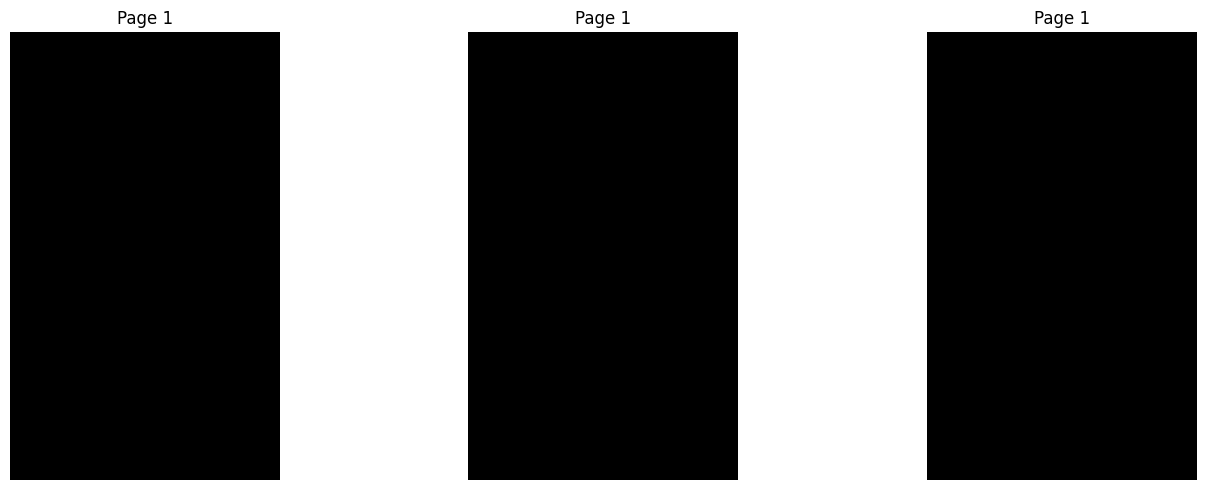

In [22]:
# Display extracted images (if any)
if chatbot.extracted_images:
    print(f"🖼️ Found {len(chatbot.extracted_images)} images:")
    
    # Try to display images using matplotlib
    try:
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        
        fig, axes = plt.subplots(1, min(3, len(chatbot.extracted_images)), figsize=(15, 5))
        if len(chatbot.extracted_images) == 1:
            axes = [axes]
        
        for i, img_info in enumerate(chatbot.extracted_images[:3]):
            if os.path.exists(img_info['path']):
                img = mpimg.imread(img_info['path'])
                axes[i].imshow(img)
                axes[i].set_title(f"Page {img_info['page_number']}")
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Install matplotlib to display images: pip install matplotlib")
        for img in chatbot.extracted_images:
            print(f"  - {img['filename']} saved to {img['path']}")
else:
    print("No images extracted from the PDF.")

## Tips for Beginners

1. **API Keys**: Make sure to set your API keys in the CONFIG section or as environment variables.

2. **PDF Path**: Update the `pdf_path` variable to point to your actual PDF file.

3. **Model Selection**: You can switch between Mistral and OpenAI by changing `CONFIG["model_provider"]`.

4. **Questions**: Modify the questions in the cells above to ask about your specific document.

5. **Images**: If your PDF has images, they will be automatically extracted and saved as JPG files.

6. **Error Handling**: If you encounter errors, make sure all required packages are installed.

## Next Steps

- Try different types of questions
- Experiment with both AI models
- Test with different PDF documents
- Modify the prompts to get better responses

Happy chatting with your PDFs! 🎉